# Simulating Systems of Springs in 2 Dimensions

This notebook will cover the method for which systems of springs can be simulated.

In [14]:
#magic codes
%matplotlib notebook
import numba

#type of display for the text section
from IPython.display import display, Math, Latex

#import libraries
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
from matplotlib import animation, rc
from scipy.integrate import odeint


Here is an example system:

$X=\begin{bmatrix} x_{1x} & x_{1y} \\ x_{2x} & x_{2y} \\ x_{3x} & x_{3y} \end{bmatrix}$
$,\ M=\begin{bmatrix} m_1 \\ m_2 \\ m_3 \end{bmatrix}$

$K=\begin{bmatrix} 0 & k & k \\ k & 0 & k \\ k & k & 0\end{bmatrix}$
$,\ L=\begin{bmatrix} 0 & l_{12} & l_{13} \\ l_{21} & 0 & l_{23} \\ l_{31} & l_{32} & 0\end{bmatrix}$

$D=\begin{bmatrix} 0 & d_{12} & d_{13} \\ d_{21} & 0 & d_{23} \\ d_{31} & d_{32} & 0 \end{bmatrix}$
$,\ d_{xy}=\frac{||\mathbf{x_x}-\mathbf{x_y}||-l_{xy}}{||\mathbf{x_x}-\mathbf{x_y}||}$

$\Delta D=\begin{bmatrix} 0 & \mathbf{x_1}-\mathbf{x_2} & \mathbf{x_1}-\mathbf{x_3} \\ \mathbf{x_2}-\mathbf{x_1} & 0 & \mathbf{x_2}-\mathbf{x_3} \\ \mathbf{x_3}-\mathbf{x_1} & \mathbf{x_3}-\mathbf{x_2} & 0\end{bmatrix}$

Using this information it should be simple to calculate the forces and then from there calculate the position, velocity and acceleration of each mass in the system.

Below is an example graph of a system described by the equations above.

<IPython.core.display.Javascript object>


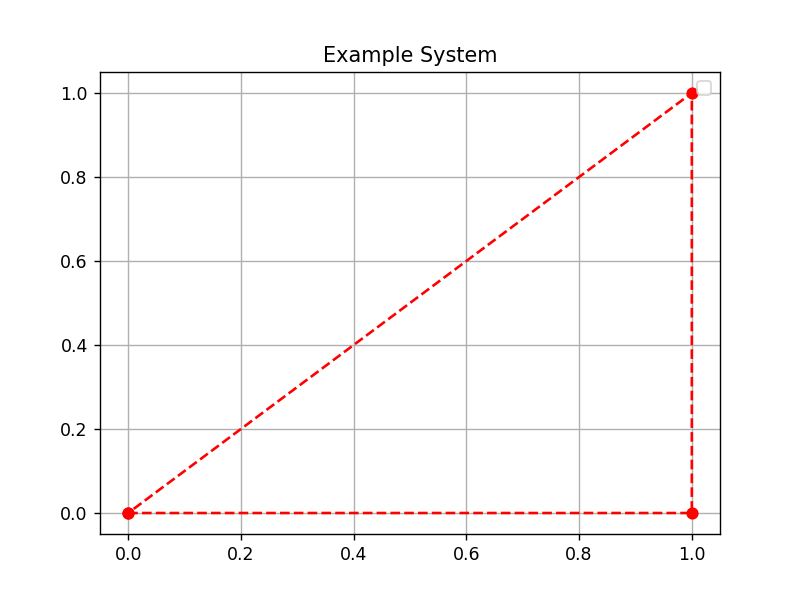

No handles with labels found to put in legend.


In [15]:
plt.title('Example System')
plt.plot([0,1,1,0], [0,0,1,0], '--ro')
plt.legend()
plt.grid()
plt.show()

Implementing the equations above in code is a little trickly becuase scipy only has an Eulers method that works on 1Xn vectors or nXm matricies. This limits the implementation below to just vectors and matricies.

Possibly a matrix like this could work:

$X_{xv}=\begin{bmatrix} x_{1x} & x_{1y} & v_{1x} & v_{1y} \\ x_{2x} & x_{2y} & v_{2x} & v_{2y} \\ x_{3x} & x_{3y} & v_{3x} & v_{3y} \end{bmatrix}$

In [16]:
@numba.jit
def calculateDiffsBetweenMasses(X_xv):
    rows = X_xv.shape[0]
    columns = d = int(X_xv.shape[1]/2)
    D_L = np.zeros(shape=(rows, columns*rows)) #left distance matrix
    D_R = np.zeros(shape=(rows, columns*rows)) #right distance matrix
    
    for i in range(0, rows):
        for j in range(0, rows):
            D_L[i,d*j:d*j+d] = X_xv[i,0:d]
            D_R[j,d*i:d*i+d] = X_xv[i,0:d]
            
    Delta_D = D_R-D_L
    return Delta_D

In [17]:
@numba.jit
def calculateMagnitudesBetweenMasses(X_xv, L):
    rows = X_xv.shape[0]
    columns = d = int(X_xv.shape[1]/2)
    D = np.zeros(shape=(rows, rows)) #square matrix of values
    
    for row_index in range(0, rows):
        for column_index in range(0, rows):
            if (row_index==column_index):
                continue
            diff = X_xv[row_index,0:d]-X_xv[column_index,0:d]
            mag = np.sqrt(np.dot(diff,diff))
            D[row_index, column_index] = (mag-L[row_index, column_index])/mag
    return D

In [18]:
@numba.jit
def calculateDifferences(X_xv, Delta_D, D, M, K, F):
    rows = X_xv.shape[0]
    columns = d = int(X_xv.shape[1]/2)
    deltas = X_xv.copy()
    
    for row_index in range(0, rows): #calculate for each mass
        if (F[row_index] == 1):
            deltas[row_index] = np.zeros(d*2)
            continue
        deltas[row_index,0:d] = deltas[row_index,d:2*d]
        deltas[row_index,d:2*d] = np.zeros(d)
        
        for sum_index in range(0, rows):
            #if (row_index==sum_index):
            #    continue
            if (K[row_index, sum_index]!=0.0): #then add to sum
                
                #VERY IMPORTAMT, the sign of Delta_D MUST be right
                deltas[row_index,d:2*d] = deltas[row_index,d:2*d] + D[row_index,
                    sum_index]*Delta_D[row_index,d*sum_index:d*sum_index+d]*K[row_index, sum_index]
            else: #the mass is not connected to this one
                continue
        #deltas[row_index, d:2*d] = (deltas[row_index, d:2*d]- (0.5)*deltas[row_index,d:2*d])/M[row_index]
        deltas[row_index, d:2*d] = (deltas[row_index, d:2*d])/M[row_index] #
    return deltas

In [19]:
def SpringSystem2D(X_xv, t, M, K, L, F, shape_working, shape_end):
    X_xv = X_xv.reshape(shape_working)
    Delta_D = calculateDiffsBetweenMasses(X_xv)
    D = calculateMagnitudesBetweenMasses(X_xv, L)
    X_xv = calculateDifferences(X_xv, Delta_D, D, M, K, F)
    X_xv = X_xv.reshape(shape_end)
    return X_xv

Here is an interesting test case that produces a ribbon type plot in 2 dimensions. This system starts out exactly like the example system from before. The spring going from point 1 to point 3 is at rest at $l_{31}=1$. The value of $l_{31}$ is originaly set to $l_{31}=\sqrt{2}$ so the system begins pushing and pulling continuously. This constant pushing and pulling produces a ribbon.

In [20]:
plt.close()
X0 = np.zeros(shape=(3,4))
X0[0] = [0,0,0,0]
X0[1] = [1,0,0,0]
X0[2] = [1,1,0,0]

M = np.ones(shape=(3,1))
M[0] = [1]
M[1] = [1]
M[2] = [1]

F = np.zeros(shape=(3,1))
F[0] = [1]
F[1] = [1]
F[2] = [0]

K = np.ones(shape=(3,3))
K[0] = [0,1,1]
K[1] = [1,0,1]
K[2] = [1,1,0]

L = np.ones(shape=(3,3))
L[0] = [0,1,1]
L[1] = [1,0,1]
L[2] = [1,1,0]

rez = 25000
end = 115.0
refresh = int(1000/(rez/end))
t = np.linspace(0, end, rez)

shape_working = X0.shape
shape_end = (X0.shape[0]*X0.shape[1],)
X0 = X0.reshape(shape_end)
sol = odeint(SpringSystem2D, X0, t, args=(M, K, L , F, shape_working, shape_end))

Now plot the above solution curve for the above system.

<IPython.core.display.Javascript object>


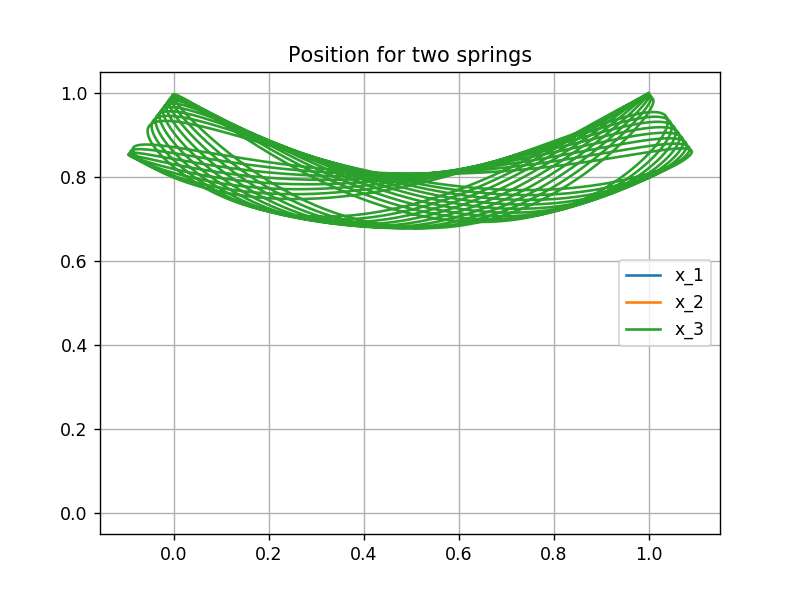

In [21]:
plt.close()
plt.title('Position for two springs')
plt.plot(sol[:,0:1], sol[:,1:2], label='x_1')
plt.plot(sol[:,4:5], sol[:,5:6], label='x_2')
plt.plot(sol[:,8:9], sol[:,9:10], label='x_3')
plt.legend()
plt.grid()
plt.show()

Here is a set of functions that can be used to graph any system.

In [22]:
def structureLattice(ax, K,solVec,dim):
    line_indexes = []
    lines = []
    initial_pos = sol[0].reshape(len(K), dim*2)
    for i in range(0,len(K)):
        for j in range(i+1, len(K)):
            #create a line if true
            if (K[i,j]!=0.0):
                new_line = ax.plot([initial_pos[i][0], initial_pos[j][0]]
                                    ,[initial_pos[i][1], initial_pos[j][1]], 'o--r')[0]
                lines.append(new_line)
                line_indexes.append((i,j))
    return (line_indexes, lines)

In [23]:
def animate2D(x_i, lines, line_indexes):
    x_i = x_i.reshape(len(K), 2*2)[0:len(K)]
    for index, value in enumerate(line_indexes):
        line = lines[index]
        i = value[0]
        j = value[1]
        line.set_xdata([x_i[i][0], x_i[j][0]])
        line.set_ydata([x_i[i][1], x_i[j][1]])
    return lines

And here is the physical perspective graphed using the above two methods. The first methods sets up the lattice and the next method update the lattice over time using a solution vector.

<IPython.core.display.Javascript object>


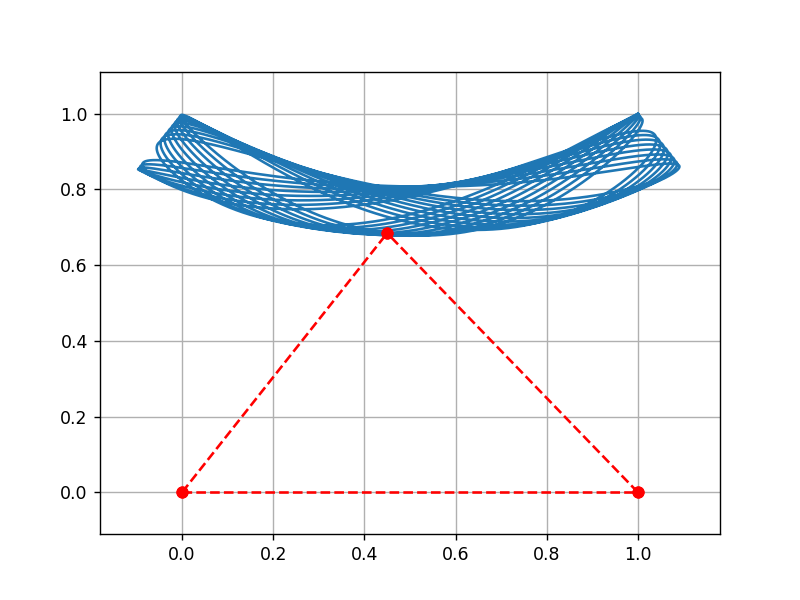

In [24]:
plt.close()
fig, ax = plt.subplots()
ax.set_xlim(-.18,1.18)
ax.set_ylim(-0.11,1.11)
ax.plot(sol[:,8:9], sol[:,9:10], label='x_3')

line_indexes, lines = structureLattice(ax, K, sol, 2)

# Init only required for blitting to give a clean slate.
def init():
    return lines

#chop off some frame to make the animation smoother
sol_copy = sol[::7]

refresh=15
ani = animation.FuncAnimation(fig, animate2D, sol_copy, fargs=[lines, line_indexes], init_func=init,
                              interval=refresh, blit=True)

plt.grid()
plt.show()


Here is a larger example.

In [25]:
plt.close()

mesh_width = 9
mesh_height = 9
dim = mesh_width*mesh_height

X0 = np.zeros(shape=(dim,4))

#fix certain points
F = np.zeros(shape=(dim,1))
#F[0] = 1
#F[mesh_width*mesh_height-mesh_height] = 1

#stiffness matrix
K = np.zeros(shape=(dim,dim))
L = np.zeros(shape=(dim,dim))

index = 0
for width_x in range(0, mesh_width):
    F[index] = 1
    for height_y in range(0, mesh_height):
        X0[index] = [width_x, height_y, 0, 0]
        index = index + 1
        
X0[3:6,2] = 0.35
X0[3:6,3] = 0.35


c_diff = mesh_width
c_diff2 = mesh_width-1

for column in range(0, dim):
    #sub_diagonal_upper = column-1 if ((column)%mesh_height!=0) else column
    sup_diagonal_upper = column+c_diff if (column+c_diff<dim) else column
    sup_diagonal_lower = column+1 if (column+1<dim and ((column+1)%mesh_height!=0)) else column
    diagonal_upper = column+c_diff2 if (column+c_diff2<dim and (column%mesh_height!=0)) else column
    #sub_diagonal_lower = column-c_diff if (column-c_diff>=0) else column
    #diagonal_left = column-c_diff2 if (column-c_diff2>=0 and ((column+1)%mesh_height!=0)) else column
    K[column, sup_diagonal_upper] = 1
    K[column, sup_diagonal_lower] = 1
    K[column, diagonal_upper] = 1
    
    K[sup_diagonal_upper,column] = 1
    K[sup_diagonal_lower,column] = 1
    K[diagonal_upper,column] = 1
    
    L[column, sup_diagonal_upper] = 1
    L[column, sup_diagonal_lower] = 1
    L[column, diagonal_upper] = np.sqrt(2)
    
    L[sup_diagonal_upper,column] = 1
    L[sup_diagonal_lower,column] = 1
    L[diagonal_upper,column] = np.sqrt(2)
    
    K[column, column] = 0
    L[column, column] = 0

#set all masses equal to one
M = 1*np.ones(shape=(dim,1))


rez = 50000
end = 100.0
refresh = int(1000/(rez/end))
t = np.linspace(0, end, rez)

shape_working = X0.shape
shape_end = (X0.shape[0]*X0.shape[1],)
X0 = X0.reshape(shape_end)
sol = odeint(SpringSystem2D, X0, t, args=(M, K, L , F, shape_working, shape_end))
print ('* solved the system')

* solved the system


<IPython.core.display.Javascript object>


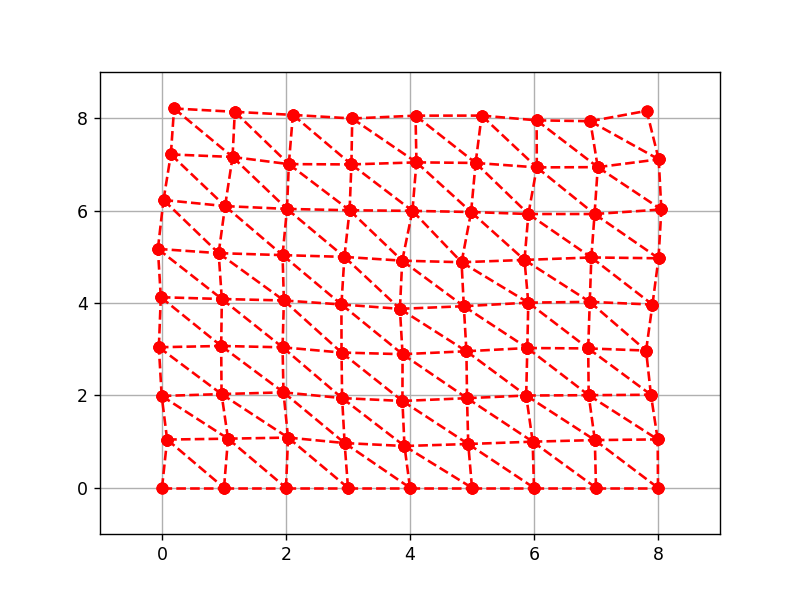

In [26]:
plt.close()
fig, ax = plt.subplots()
ax.set_xlim(-1,mesh_width)
ax.set_ylim(-1,mesh_height)
#ax.plot(sol[:,8:9], sol[:,9:10], label='x_3')

line_indexes, lines = structureLattice(ax, K, sol, 2)

# Init only required for blitting to give a clean slate.
def init():
    return lines

#chop off some frame to make the animation smoother
sol_copy = sol[::100]

refresh=7
ani = animation.FuncAnimation(fig, animate2D, sol_copy, fargs=[lines, line_indexes], init_func=init,
                              interval=refresh, blit=True, save_count=50)

plt.grid()
plt.show()